<a href="https://colab.research.google.com/github/francesco-source/DeepLearning/blob/main/image_inpainting/VAE_dense_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import utils
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

170498071/170498071 [==============================] - 13s 0us/step
image range is 0, 255
new image range is 0.0, 1.0


In [ ]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X

masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

x_train.shape
masked_x_train.shape

(50000, 32, 32, 3)

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
input_dim = 32*32*3

latent_dim = 16
intermediate_dim_1 = 64
intermediate_dim_2 = 128

In [ ]:
x = layers.Input(shape=(input_dim,))
x_reshaped = layers.Reshape((32, 32, 3), input_shape=(input_dim,))(x)

h = layers.Conv2D(8, kernel_size=7, activation='swish', padding='same')(x_reshaped)
h = layers.MaxPooling2D(pool_size=2)(h)
h = layers.Conv2D(16, kernel_size=7, activation='swish', padding='same')(h)
h = layers.MaxPooling2D(pool_size=2)(h)
h = layers.Flatten()(h)
h = layers.Dense(intermediate_dim_1, activation='swish')(h)
h = layers.Dense(intermediate_dim_2, activation='swish')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

encoder = Model(x, [z_mean, z_log_var])

In [ ]:
z = layers.Input(shape=(latent_dim,))
dec_mid_1 = layers.Dense(intermediate_dim_2, activation='swish')(z)
dec_mid_2 = layers.Dense(intermediate_dim_1, activation='swish')(dec_mid_1)
reshape = layers.Reshape((8,8,1))(dec_mid_2)
dec_deconv1 = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='swish', padding='same')(reshape)
dec_deconv2 = layers.Conv2DTranspose(filters=32, kernel_size=3, strides=1, activation='swish', padding='same')(dec_deconv1)
flat = layers.Flatten()(dec_deconv2)
x_hat = layers.Dense(input_dim,activation='sigmoid')(flat)

decoder = Model(inputs=z, outputs=[x_hat])

In [ ]:
m = layers.Input(shape=(input_dim,))
z_mean, z_log_var = encoder(m)
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_hat = decoder(z)

vae = Model(m,x_hat)

In [ ]:
beta = 1. #a balancing factor
rec_loss = input_dim * metrics.mean_squared_error(m, x_hat)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(rec_loss + beta * kl_loss)
vae.add_loss(vae_loss)

In [ ]:
batch_size = 100
epochs = 20

In [ ]:
vae.compile(optimizer=Adam(learning_rate=0.0001),metrics = ["mse"])

In [ ]:
# Flatten the input images
masked_x_train_flat = masked_x_train.reshape(-1, input_dim)
x_train_flat = x_train.reshape(-1, input_dim)

# Train the VAE model
vae.fit(masked_x_train_flat, x_train_flat, shuffle = True, epochs=epochs, batch_size=batch_size, validation_split=0.1)


Epoch 1/20
450/450 [==============================] - 18s 9ms/step - loss: 149.9712 - mse: 0.1251 - val_loss: 91.6405 - val_mse: 0.1328
Epoch 2/20
450/450 [==============================] - 4s 9ms/step - loss: 81.4014 - mse: 0.1301 - val_loss: 73.1037 - val_mse: 0.1274
Epoch 3/20
450/450 [==============================] - 3s 8ms/step - loss: 70.0025 - mse: 0.1269 - val_loss: 67.6949 - val_mse: 0.1260
Epoch 4/20
450/450 [==============================] - 3s 7ms/step - loss: 67.4119 - mse: 0.1265 - val_loss: 65.5086 - val_mse: 0.1255
Epoch 5/20
450/450 [==============================] - 4s 8ms/step - loss: 65.4974 - mse: 0.1260 - val_loss: 63.0596 - val_mse: 0.1248
Epoch 6/20
450/450 [==============================] - 4s 8ms/step - loss: 63.4224 - mse: 0.1252 - val_loss: 61.8800 - val_mse: 0.1243
Epoch 7/20
450/450 [==============================] - 3s 7ms/step - loss: 62.4707 - mse: 0.1249 - val_loss: 61.0702 - val_mse: 0.1240
Epoch 8/20
450/450 [==============================] - 3s 7ms

In [ ]:
masked_x_test_flat = masked_x_test.reshape(-1, input_dim)

predictions = vae.predict(x=masked_x_test_flat, verbose=0)

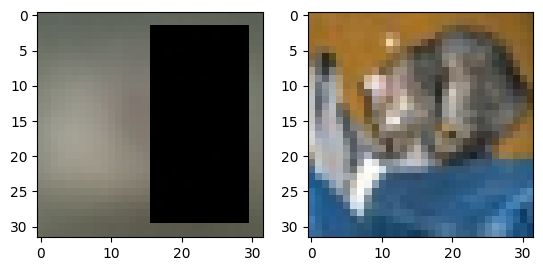

In [ ]:
prediction = predictions[0].reshape((32,32,3))


plt.subplot(1,2,1)
plt.imshow(prediction)
plt.subplot(1,2,2)
plt.imshow(x_test[0])

Doesn't work at all